In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from src.classes.ClassFractionalSin import FractionalSin
from tqdm import tqdm
import numpy as np
import math
from scipy.special import eval_laguerre
from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_fSinWithPosition_T256_H05_tl_5data import get_config

# From Nonparametric drift estimation for IID paths of SDE (Comte et al 2020)

In [2]:
config = get_config()

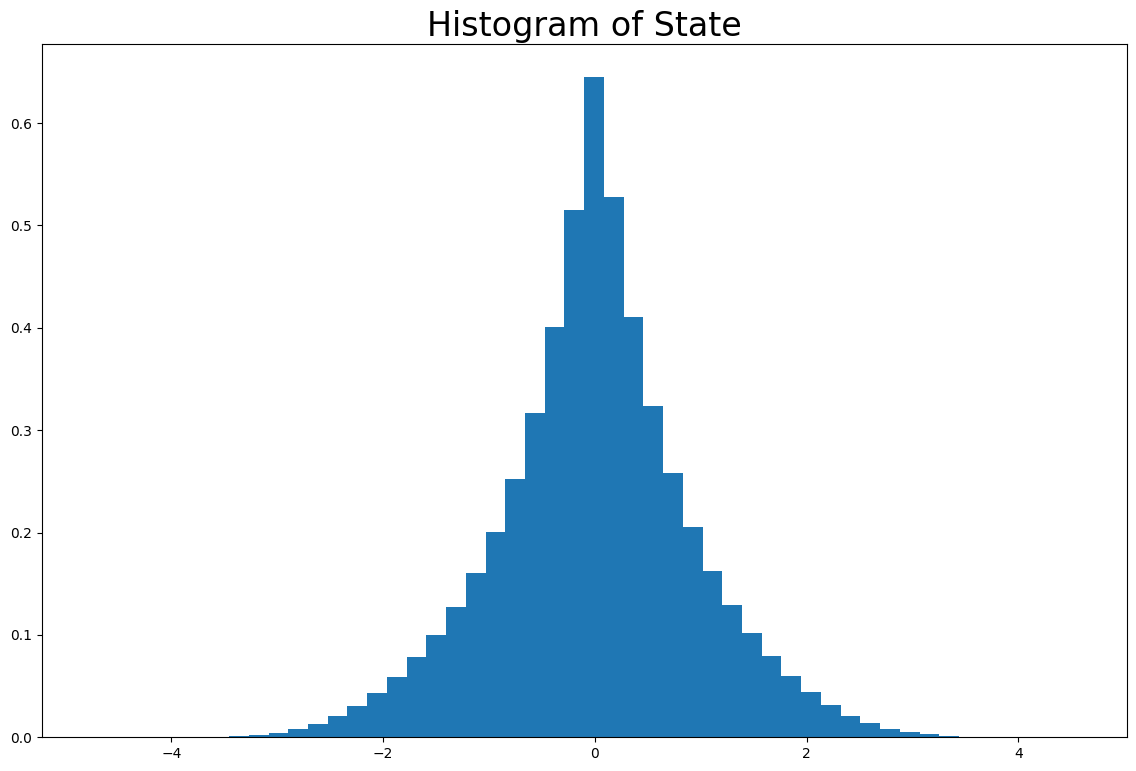

In [3]:
num_paths = int(1.25e5)
num_time_steps = int(256)
isUnitInterval = True
mean_rev = config.mean_rev
diff = config.diffusion
initial_state = 0.
rvs = None
H = config.hurst
deltaT = 1./ (256)
t0 = 0.
t1 = deltaT*num_time_steps
space_scale = 1.
fSin = FractionalSin(mean_rev=mean_rev, diff=diff, X0=initial_state, space_scale=space_scale)
paths = np.array(
    [fSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=0, Ms=None, gaussRvs=rvs,
                           t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
    (num_paths, num_time_steps+1))
true_drift = mean_rev * np.sin(space_scale*paths[:,:-1])
fig, ax = plt.subplots(figsize=(14,9))
plt.hist(paths.flatten(), bins=50, density=True)
plt.title("Histogram of State", fontsize=24)
plt.show()
plt.close()

In [4]:
def hermite_basis(R, paths):
    assert (paths.shape[0] > 1 and len(paths.shape)==2)
    basis = np.zeros((paths.shape[0],paths.shape[1], R))
    polynomials = np.zeros((paths.shape[0],paths.shape[1], R))
    for i in range(R):
        if i == 0:
            polynomials[:, :, i] = np.ones_like(paths)
        elif i == 1:
            polynomials[:,:, i] = paths
        else:
            polynomials[:,:, i] = 2*paths*polynomials[:,:,i-1]-2*(i-1)*polynomials[:,:,i-2]
        basis[:,:,i] = np.power((np.power(2, i)*np.sqrt(np.pi)*math.factorial(i)),-0.5)*polynomials[:,:,i]*np.exp(-np.power(paths,2)/2.)
        #basis[:,:, i] = np.power((np.power(2, i)*np.sqrt(np.pi)*math.factorial(i)),-0.5)*hermite(i,monic=True)(paths)*np.exp(-np.power(paths,2)/2.)
    return basis

def laguerre_basis(R, paths):
    basis = np.zeros((paths.shape[0],paths.shape[1], R))
    for i in range(R):
        basis[:,:, i] = np.sqrt(2.)*eval_laguerre(i, 2.*paths)*np.exp(-paths)*(paths>=0.)
    return basis

In [5]:
def perfect_observation_regression(paths, true_drift, basis_type):
    paths = paths[:, :-1]
    Z_true_drift = true_drift.flatten()[:, np.newaxis]
    rmses = {}
    for r in tqdm(range(1, 100,20)):
        basis = hermite_basis(r, paths) if basis_type == "hermite" else laguerre_basis(r, paths)
        basis = basis.reshape((np.prod(paths.shape), r))
        Z = np.linalg.inv(basis.T@basis)@(basis.T@Z_true_drift)
        drift = basis @ Z
        if np.all(np.isfinite(Z)):
            rmses.update({r:np.linalg.norm(Z_true_drift.flatten()-drift.flatten())/np.sqrt(drift.shape[0])})
        else:
            rmses.update({r:np.inf})
    rmses = dict(sorted(rmses.items(), key=lambda item: item[1]))
    print(rmses)
    for r in list(rmses.keys())[:1]:
        basis = hermite_basis(r, paths) if basis_type == "hermite" else laguerre_basis(r, paths)
        Z_basis = basis.reshape((np.prod(paths.shape), r))
        Z = np.linalg.inv(Z_basis.T@Z_basis)@(Z_basis.T@Z_true_drift)
        for j in range(0,paths.shape[0], 20):
            plt.scatter(paths[j,:], true_drift[j,:],s=10, label="True")
            plt.scatter(paths[j,:], basis[j,:,:]@Z, s=10,label="Est")
            plt.legend()
            plt.show()
            plt.close()
basis_type = "hermite"
#perfect_observation_regression(paths=paths, true_drift=true_drift,basis_type=basis_type)

In [ ]:
def construct_Z_vector(R, T, basis,paths):
    assert(basis.shape[0] == paths.shape[0])
    assert(basis.shape[1] == paths.shape[1])
    basis = basis[:,:-1,:]
    assert (basis.shape[-1] == R)
    N, _ = basis.shape[:2]
    dXs = np.diff(paths, axis=1) / T
    Z = np.diagonal(basis.transpose((2,0,1))@(dXs.T), axis1=1, axis2=2).mean(axis=-1, keepdims=True)
    assert (Z.shape == (R, 1)), f"Z vector is shape {Z.shape} but should be {(R,1)}"
    return Z

def construct_Phi_matrix(R, deltaT,T, basis,paths):
    assert(basis.shape[0] == paths.shape[0])
    assert(basis.shape[1] == paths.shape[1])
    basis = basis[:,:-1,:]
    assert (basis.shape[-1] == R)
    N, _ = basis.shape[:2]
    deltaT /= T
    intermediate = deltaT*basis.transpose((0,2,1))@basis
    assert intermediate.shape == (N, R, R), f"Intermidate matrix is shape {intermediate.shape} but shoould be {(N,R,R)}"
    for i in range(N):
        es = np.linalg.eigvalsh(intermediate[i,:,:]) >= 0.
        assert (np.all(es)), f"Submat at {i} is not PD"
    Phi = deltaT*(basis.transpose((0,2,1))@basis).mean(axis=0, keepdims=False)
    assert (Phi.shape == (R, R)), f"Phi matrix is shape {Phi.shape} but should be {(R,R)}"
    assert np.all(np.linalg.eigvalsh(Phi) >= 0.), f"Phi matrix is not PD"
    return Phi

def estimate_coefficients(R, deltaT,t1, basis,paths):
    Z = construct_Z_vector(R=R, T=t1,basis=basis,paths=paths)
    Phi = construct_Phi_matrix(R=R, deltaT=deltaT,T=t1,basis=basis,paths=paths)
    theta_hat = np.linalg.solve(Phi, Z)
    assert (theta_hat.shape == (R, 1))
    return theta_hat


def construct_drift(basis, coefficients):
    b_hat =  (basis @ coefficients).squeeze(-1)
    assert (b_hat.shape == basis.shape[:2]), f"b_hat should be shape {basis.shape[:2]}, but has shape {b_hat.shape}"
    return b_hat


R = 6
basis = hermite_basis(R=R, paths=paths[:,:])
coeffs = (estimate_coefficients(R=R, deltaT=deltaT, basis=basis, paths=paths[:,:], t1=t1))
bhat = construct_drift(basis=basis, coefficients=coeffs)
vis_paths = paths[:,:-1].flatten()
vis_td = true_drift.flatten()
plt.scatter(vis_paths, true_drift,s=10, color="cyan", label="True")
for j in range(0,paths[:,:].shape[0]):
    plt.plot(paths[j,:-1], bhat[j,:-1], alpha=0.25,color="magenta")
plt.show()
plt.close()